# 2. Cluster Habitat Data
This notebook works through an approach to cluster habitat data in order to mitigate spatial dependencies between samples.

## Setup

In [1]:
import os

In [2]:
import random

In [3]:
import numpy as np

In [4]:
import pandas as pd

In [5]:
import matplotlib.pyplot as plt

In [6]:
import matplotlib.colors as mcolors

In [7]:
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

In [8]:
import geopandas as gpd

In [9]:
import contextily as cx

In [10]:
from sklearn.cluster import DBSCAN

In [11]:
from shapely.geometry import Point

In [12]:
DATA_DIR = '../data/'

In [13]:
FIGURES_DIR = '../saved_figures/'

## Load habitat data

### OSPAR Habitats 2022

In [14]:
ospar_shp = os.path.join(DATA_DIR, 'OSPARHabitats2022_Points_mod/OSPAR2022Points.shp')

In [15]:
gdf = gpd.read_file(ospar_shp)

In [16]:
gdf.head()

,GUI,RecordKey,HabType,HabSubType,HabStatus,Determiner,DetDate,SurveyKey,StartDate,EndDate,...,DataOwner,Accuracy,Latitude,Longitude,AltHabType,AltHabClas,AltHabRel,SurveyDate,SurveyYear,geometry
0,OSPARHab2010IE1v0,10100105,Zostera beds,Unknown,Present,None,None,None,2003-07-01,2003-10-31,...,None,None,55.045203,-7.125105,None,None,None,2003-10-31,2003,POINT (-7.12511 55.0452)
1,OSPARHab2010IE1v0,10100039,Zostera beds,Zostera noltii beds,Present,L Lieberkencht,2002-08-01,None,1996-05-01,1996-12-31,...,Trinity College Dublin,None,52.669012,-9.569316,None,None,None,1996-12-31,1996,POINT (-9.56932 52.66901)
2,OSPARHab2010IE1v0,10100020,Zostera beds,Zostera noltii beds,Present,L Lieberkencht,2002-09-03,None,1996-05-01,1996-12-31,...,Trinity College Dublin,None,52.305249,-9.854169,None,None,None,1996-12-31,1996,POINT (-9.85417 52.30525)
3,OSPARHab2010IE1v0,10100013,Zostera beds,Zostera noltii beds,Present,L Lieberkencht,2002-09-04,None,1996-05-01,1996-12-31,...,Trinity College Dublin,None,52.142788,-9.943158,None,None,None,1996-12-31,1996,POINT (-9.94316 52.14279)
4,OSPARHab2010IE1v0,10100024,Zostera beds,Zostera marina beds,Present,JH Allen,2003-06-13,None,1996-05-01,1996-12-31,...,Trinity College Dublin,None,52.264474,-9.825030,None,None,None,1996-12-31,1996,POINT (-9.82503 52.26447)


In [17]:
gdf.HabType.unique()

array(['Zostera beds', 'Intertidal mudflats', 'Maerl beds',
       'Ostrea edulis beds',
       'Sea-pen and burrowing megafauna communities',
       'Deep-sea sponge aggregations', 'Lophelia pertusa reefs',
       'Carbonate mounds', 'Coral gardens', 'Kelp forests',
       'Intertidal Mytilus edulis beds on mixed and sandy sediments',
       'Modiolus modiolus horse mussel beds', 'Seamounts',
       'Oceanic ridges with hydrothermal vents/fields',
       'Sabellaria spinulosa reefs', 'Littoral chalk communities'],
      dtype=object)

In [18]:
gdf['SurveyYear'] = pd.to_datetime(gdf['SurveyDate']).dt.year

## Plot data

### HabType spatial distribution

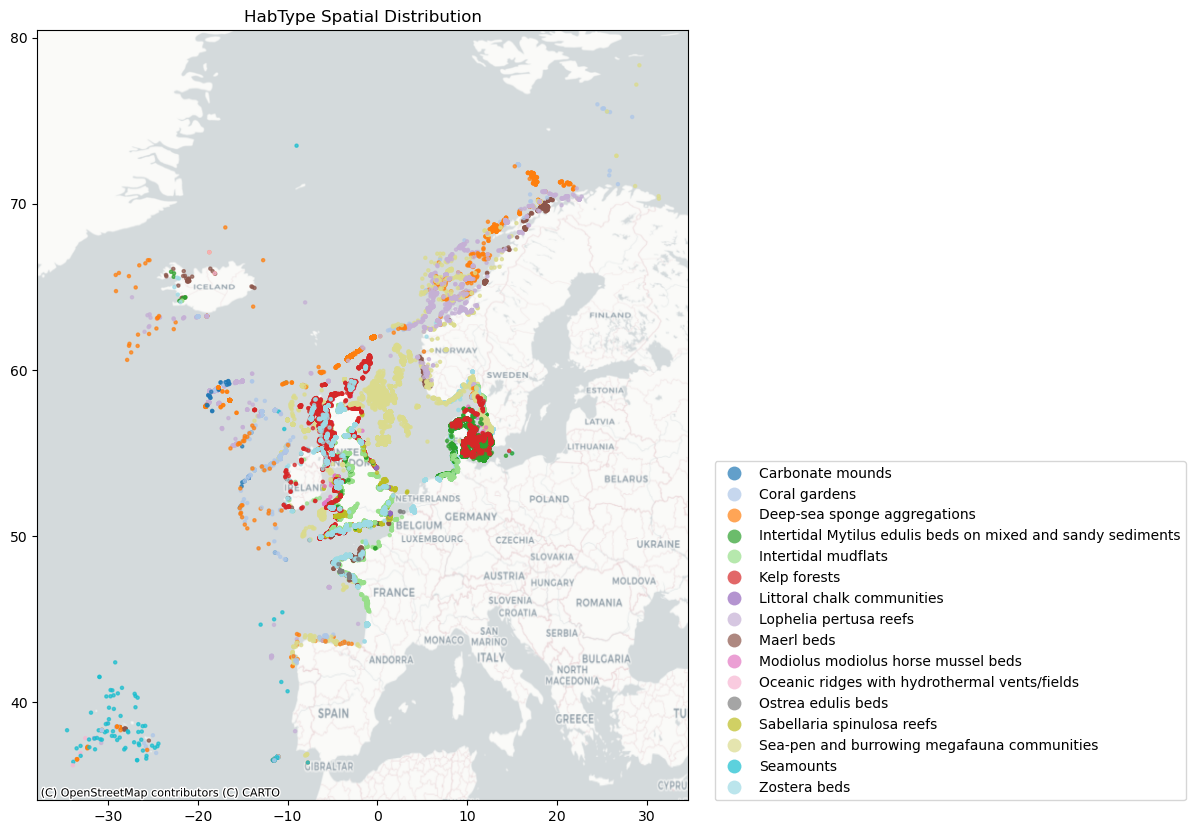

In [19]:
fig, ax = plt.subplots(figsize=(10, 10))

gdf.plot(ax=ax, column=gdf["HabType"], cmap='tab20', markersize=5, alpha=0.7,
         legend=True, categorical=True, legend_kwds={'loc': (1.04, 0)})

ax.set_title("HabType Spatial Distribution")
cx.add_basemap(ax, crs=gdf.crs, source=cx.providers.CartoDB.Positron)

plt.show()

### SurveyKey spatial distribution

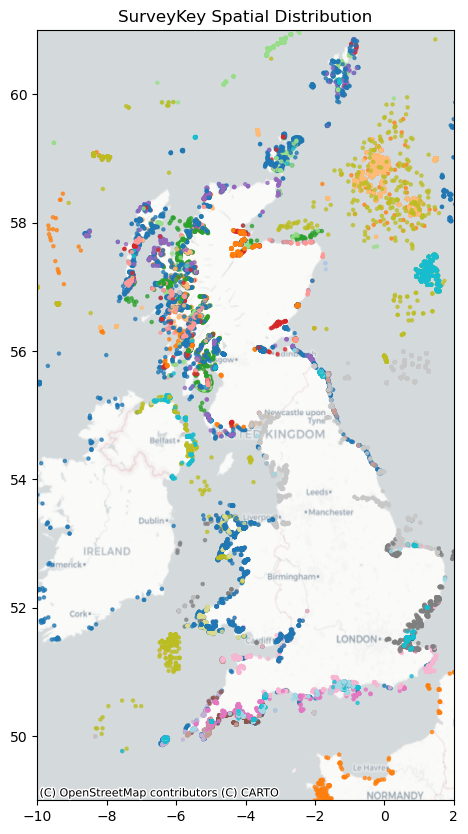

In [20]:
fig, ax = plt.subplots(figsize=(10, 10))

# Get unique SurveyKey values
unique_surveys = gdf["SurveyKey"].unique()

# Generate a colormap
cmap = plt.get_cmap("tab20", len(unique_surveys))

# Create a color mapping
color_map = {survey: cmap(i) for i, survey in enumerate(unique_surveys)}
gdf["survey_color"] = gdf["SurveyKey"].map(color_map)

# Plot
gdf.plot(ax=ax, color=gdf["survey_color"], markersize=5, alpha=0.7)

# Zoom into the UK
ax.set_xlim([-10, 2])
ax.set_ylim([49, 61])
ax.set_title("SurveyKey Spatial Distribution")
cx.add_basemap(ax, crs=gdf.crs, source=cx.providers.CartoDB.Positron)

# Create a custom legend
# handles = [plt.Line2D([0], [0], marker='o', color='w', markersize=6, markerfacecolor=color_map[survey]) 
#            for survey in unique_surveys]
# ax.legend(handles, unique_surveys, title="SurveyKey", loc="upper right", fontsize="small")

plt.show()

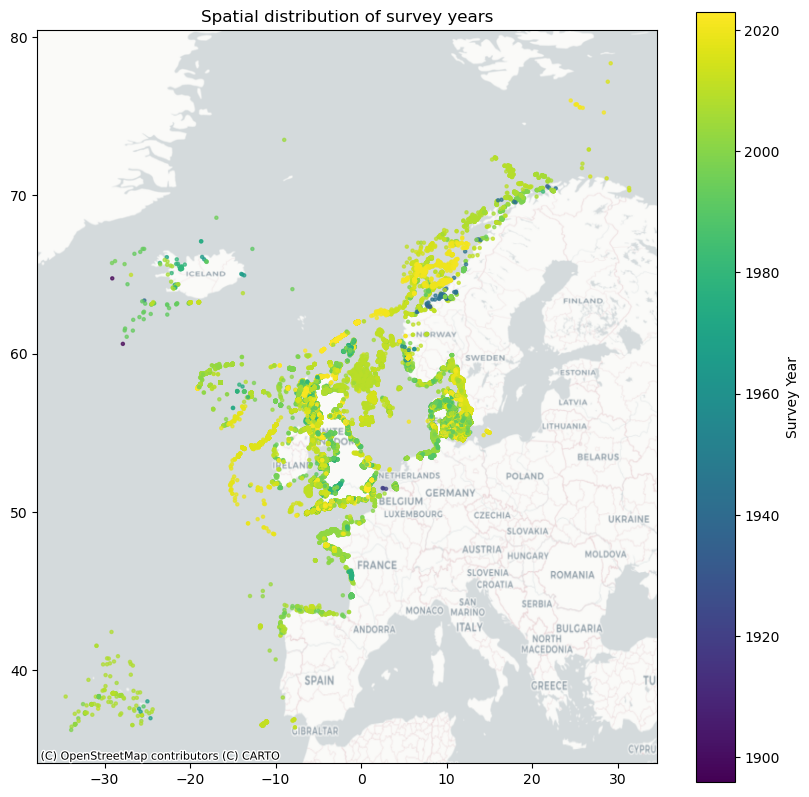

In [21]:
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, column=gdf['SurveyYear'], cmap='viridis', markersize=5, alpha=0.7)
norm = Normalize(vmin=gdf['SurveyYear'].min(), vmax=gdf['SurveyYear'].max())
sm = ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Survey Year')
cx.add_basemap(ax, crs=gdf.crs, source=cx.providers.CartoDB.Positron)
ax.set_title('Spatial distribution of survey years')
plt.show()

## Clustering

In [22]:
gdf = gdf.set_crs('EPSG:4326')

In [23]:
gdf = gdf.to_crs('EPSG:32630')

### DBSCAN

In [24]:
eps = 5000
min_samples = 3

In [ ]:
# # Initialize the cluster column
# gdf["Cluster"] = -1

# # Ensure unique cluster IDs
# cluster_id_offset = 0

# # Loop through each HabType group
# for hab, subset in gdf.groupby("HabType"):
#     # Extract coordinates for the entire HabType group
#     coords = np.vstack((subset.geometry.x, subset.geometry.y)).T
    
#     # Apply DBSCAN with fixed parameters to the whole HabType group
#     dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric="euclidean").fit(coords)
#     labels = dbscan.labels_
    
#     # Split by SurveyYear within this HabType group for assignment
#     for year, year_subset in subset.groupby("SurveyYear"):
#         # Get the indices of this SurveyYear subset within the HabType group
#         subset_indices = year_subset.index
#         # Map the DBSCAN labels to these indices
#         subset_labels = labels[subset.index.isin(subset_indices)]
        
#         # Adjust labels to be globally unique (excluding noise, which remains -1)
#         new_labels = np.where(subset_labels == -1, -1, subset_labels + cluster_id_offset)
        
#         # Store results
#         gdf.loc[subset_indices, "Cluster"] = new_labels
        
#         # Update the offset only if there are non-noise clusters
#         if np.any(new_labels != -1):
#             cluster_id_offset = gdf["Cluster"].max() + 1

In [25]:
# Initialise the cluster column
gdf["Cluster"] = -1

# Ensure unique cluster ids
cluster_id_offset = 0

# Loop through each (SurveyKey, HabType) group
for hab, subset in gdf.groupby("HabType"):
    # if len(subset) < min_samples:
    #     continue
    
    coords = np.vstack((subset.geometry.x, subset.geometry.y)).T  # Extract coordinates

    # Apply DBSCAN with fixed parameters
    dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric="euclidean").fit(coords)
    labels = dbscan.labels_
    
    # Adjust labels to be globally unique (excluding noise, which remains -1)
    new_labels = np.where(labels == -1, -1, labels + cluster_id_offset)
    
    # Store results
    gdf.loc[subset.index, "Cluster"] = new_labels

    # Update the offset (avoid overlapping cluster numbers)
    cluster_id_offset = gdf["Cluster"].max() + 1

In [26]:
# Replace -1 label with unique labels
noise_subset = np.where(gdf["Cluster"] == -1)[0]
n_noise = len(noise_subset)
noise_labels = np.arange(cluster_id_offset, cluster_id_offset + n_noise)

In [27]:
gdf.loc[noise_subset, "Cluster"] = noise_labels

In [28]:
(gdf["Cluster"] == -1).any()

False

### Visualise clusters

In [29]:
gdf = gdf.to_crs('EPSG:4326')

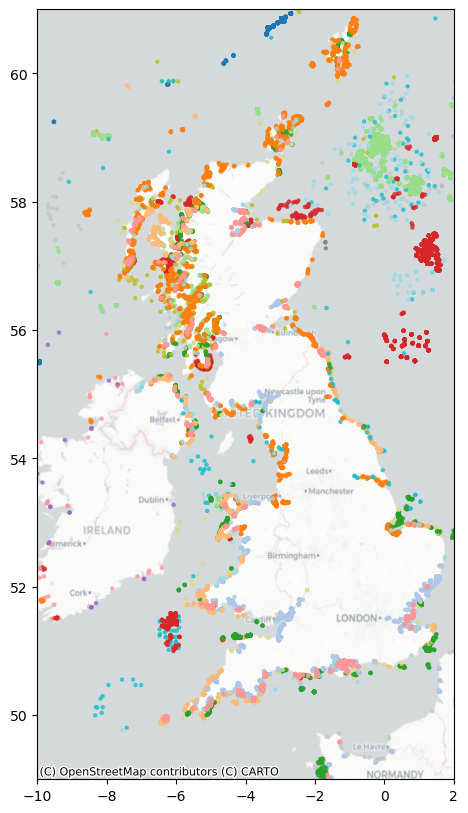

In [30]:
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(
    column='Cluster',
    categorical=True,
    cmap='tab20',
    ax=ax,
    markersize=5,
    alpha=0.7
)

ax.set_xlim([-10, 2])
ax.set_ylim([49, 61])
cx.add_basemap(ax, crs=gdf.crs, source=cx.providers.CartoDB.Positron)
plt.show()

In [31]:
# Generate distinct colors
n_clusters = gdf["Cluster"].nunique()
colors = plt.cm.tab20(np.linspace(0, 1, n_clusters))  # Sample tab20 colors
random.seed(101)
random.shuffle(colors)  # Shuffle colors for maximum contrast

# Create a color mapping
cluster_colors = {cluster_id: colors[i] for i, cluster_id in enumerate(sorted(gdf["Cluster"].unique()))}

# Apply shuffled colors
gdf["color"] = gdf["Cluster"].map(cluster_colors)

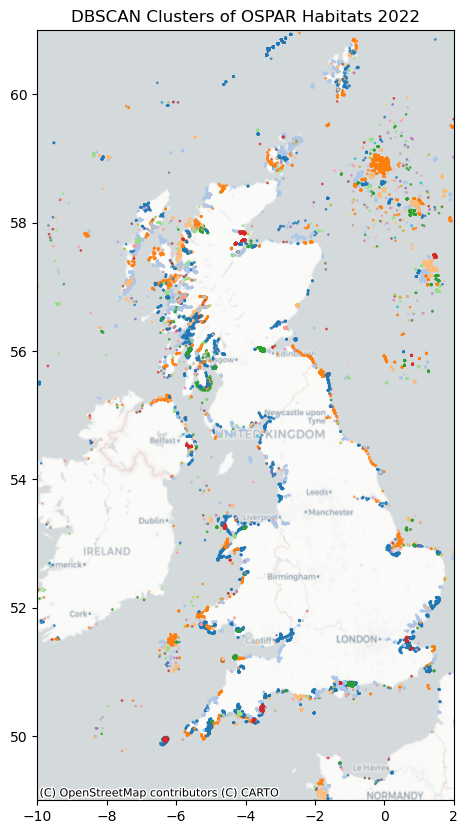

In [32]:
fig, ax = plt.subplots(figsize=(10,10))
gdf.plot(color=gdf["color"], legend=True, ax=ax, markersize=1, alpha=0.7)

ax.set_title('DBSCAN Clusters of OSPAR Habitats 2022')
ax.set_xlim([-10, 2])
ax.set_ylim([49, 61])
# ax.set_xlim([-7, -3])
# ax.set_ylim([49.5, 51.5])

cx.add_basemap(ax, crs=gdf.crs, source=cx.providers.CartoDB.Positron)

In [33]:
zostera_gdf = gdf[gdf["HabType"] == "Zostera beds"]
kelp_gdf = gdf[gdf["HabType"] == "Kelp forests"]

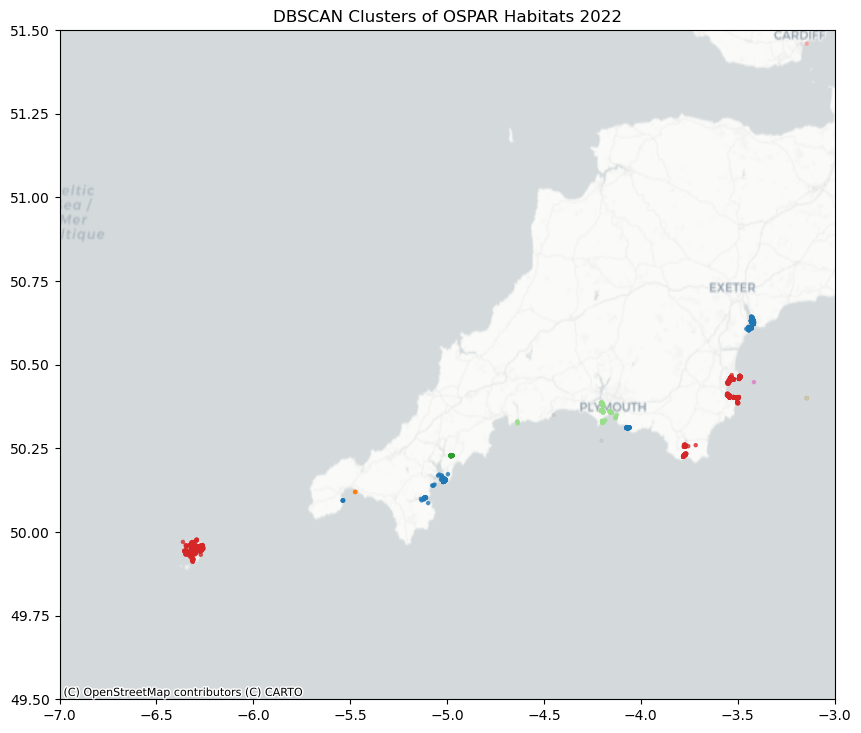

In [34]:
fig, ax = plt.subplots(figsize=(10, 10))
zostera_gdf.plot(color=zostera_gdf["color"], legend=False, ax=ax, markersize=5, alpha=0.7)
ax.set_xlim([-7, -3])
ax.set_ylim([49.5, 51.5])
ax.set_title("DBSCAN Clusters of OSPAR Habitats 2022")
cx.add_basemap(ax, crs=zostera_gdf.crs, source=cx.providers.CartoDB.Positron)
plt.show()

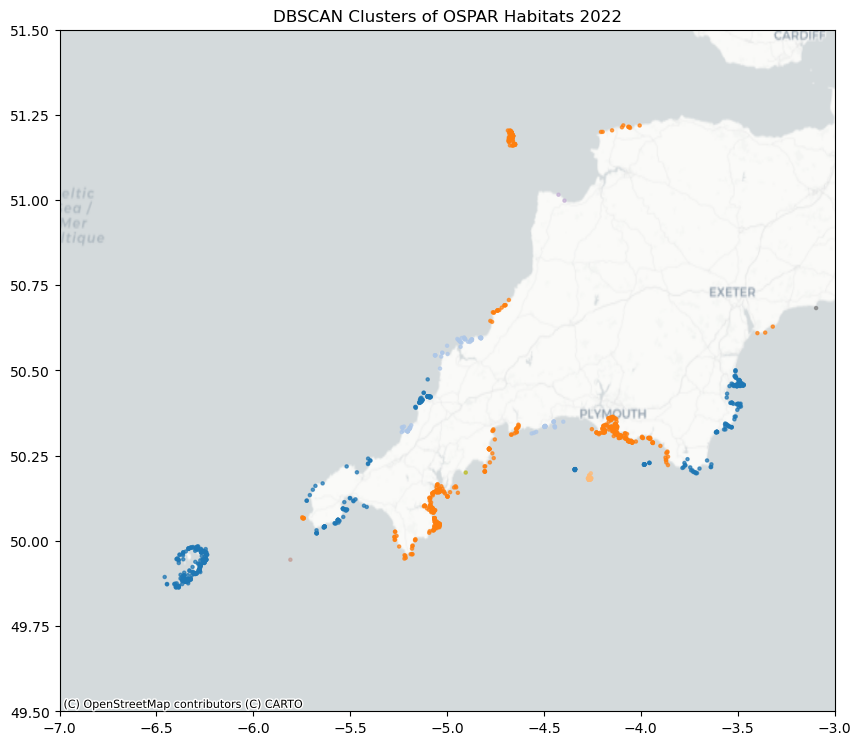

In [35]:
fig, ax = plt.subplots(figsize=(10, 10))
kelp_gdf.plot(color=kelp_gdf["color"], legend=False, ax=ax, markersize=5, alpha=0.7)
ax.set_xlim([-7, -3])
ax.set_ylim([49.5, 51.5])
ax.set_title("DBSCAN Clusters of OSPAR Habitats 2022")
cx.add_basemap(ax, crs=kelp_gdf.crs, source=cx.providers.CartoDB.Positron)
plt.show()

In [36]:
# Count clusters per HabType (excluding noise)
cluster_counts = gdf.groupby("HabType")["Cluster"].nunique()
total_counts = gdf.groupby("HabType")["Cluster"].count()  # Total points per habitat type
avg_cluster_size = total_counts / cluster_counts

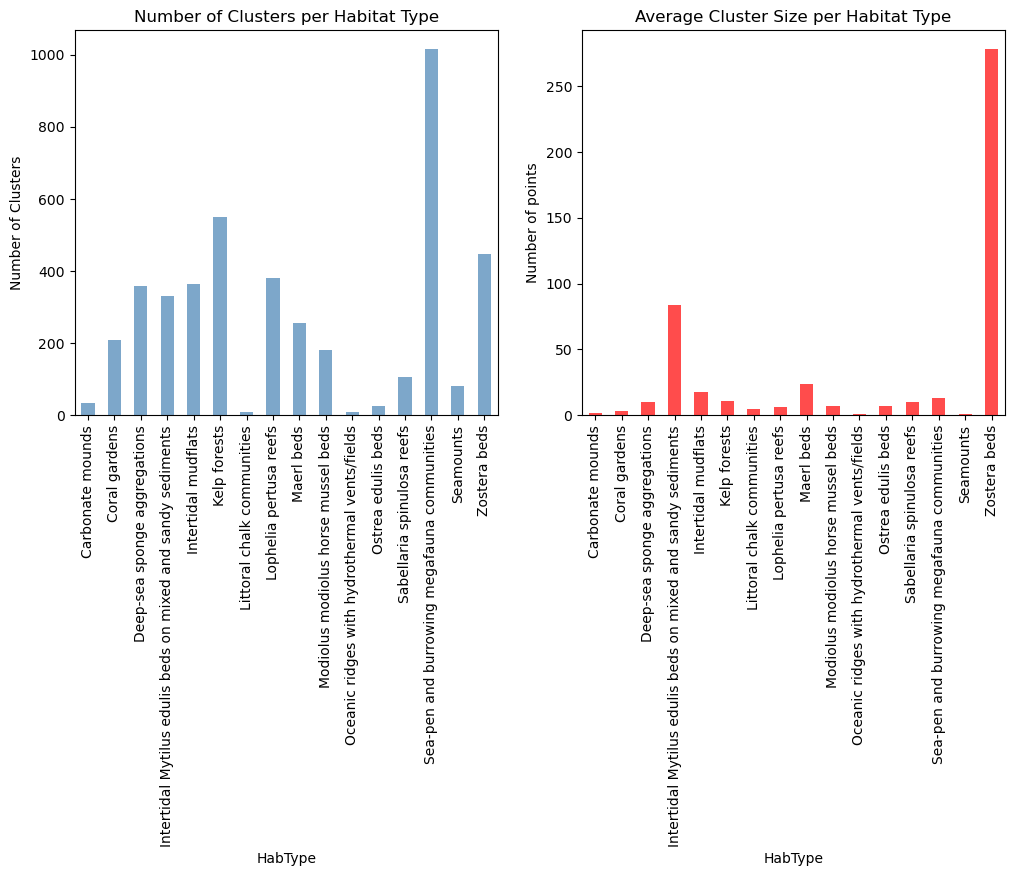

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Histogram 1: Number of Clusters per HabType
cluster_counts.plot(kind="bar", ax=axes[0], color="steelblue", alpha=0.7)
axes[0].set_title("Number of Clusters per Habitat Type")
axes[0].set_xlabel("HabType")
axes[0].set_ylabel("Number of Clusters")
axes[0].tick_params(axis="x", rotation=90)

# Histogram 2: Average cluster size per HabType
avg_cluster_size.plot(kind="bar", ax=axes[1], color="red", alpha=0.7)
axes[1].set_title("Average Cluster Size per Habitat Type")
axes[1].set_xlabel("HabType")
axes[1].set_ylabel("Number of points")
axes[1].tick_params(axis="x", rotation=90)

plt.show()

In [38]:
gdf = gdf.to_crs('EPSG:32630')

In [39]:
centroids = gdf.groupby(['HabType', 'Cluster'])['geometry'].apply(
    lambda x: Point(x.centroid.x.mean(), x.centroid.y.mean())
).reset_index()

cluster_colors = gdf.groupby('Cluster')['color'].first().reset_index()

centroids = centroids.merge(cluster_colors, on='Cluster')

# Create a GeoDataFrame for centroids
centroids_gdf = gpd.GeoDataFrame(
    centroids,
    geometry='geometry',
    crs=gdf.crs
)

In [40]:
gdf = gdf.to_crs('EPSG:4326')
centroids_gdf = centroids_gdf.to_crs('EPSG:4326')

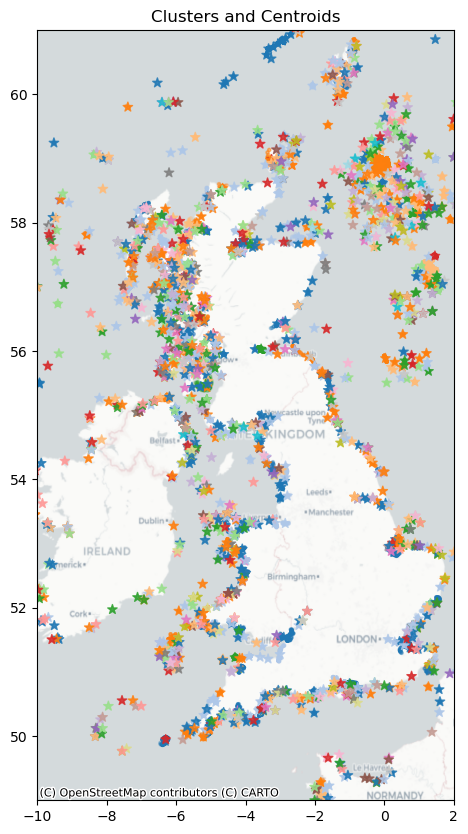

In [41]:
# Create the plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot original points, colored by cluster
gdf.plot(color=gdf["color"], ax=ax, markersize=5, alpha=0.3)

# Plot centroids
centroids_gdf.plot(ax=ax, color=centroids_gdf["color"], marker='*', markersize=50, alpha=0.8)
# ax.set_xlim([-7, -3])
# ax.set_ylim([49.5, 51.5])
ax.set_xlim([-10, 2])
ax.set_ylim([49, 61])

ax.set_title('Clusters and Centroids')
cx.add_basemap(ax, crs=gdf.crs, source=cx.providers.CartoDB.Positron)

plt.show()

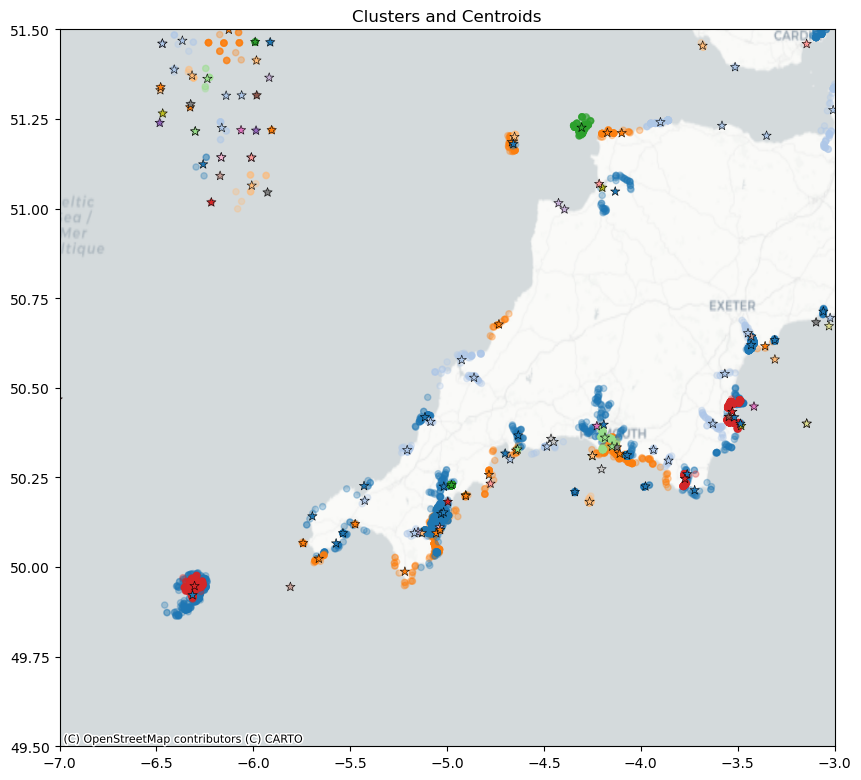

In [42]:
# Create the plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot original points, colored by cluster
gdf.plot(color=gdf["color"], legend=True, ax=ax, markersize=20, alpha=0.3)
cx.add_basemap(ax, crs=gdf.crs, source=cx.providers.CartoDB.Positron)

# Plot centroids
centroids_gdf.plot(ax=ax, color=centroids_gdf["color"], marker='*', markersize=50, edgecolor='black', linewidth=0.4)
ax.set_xlim([-7, -3])
ax.set_ylim([49.5, 51.5])
# ax.set_xlim([-10, 2])
# ax.set_ylim([49, 61])

ax.set_title('Clusters and Centroids')

cx.add_basemap(ax, crs=gdf.crs, source=cx.providers.CartoDB.Positron)
plt.show()
fig.savefig(os.path.join(FIGURES_DIR, 'clusters_sw.png'))

In [43]:
zostera_centroids = centroids_gdf[centroids_gdf["HabType"] == "Zostera beds"]
kelp_centroids = centroids_gdf[centroids_gdf["HabType"] == "Kelp forests"]

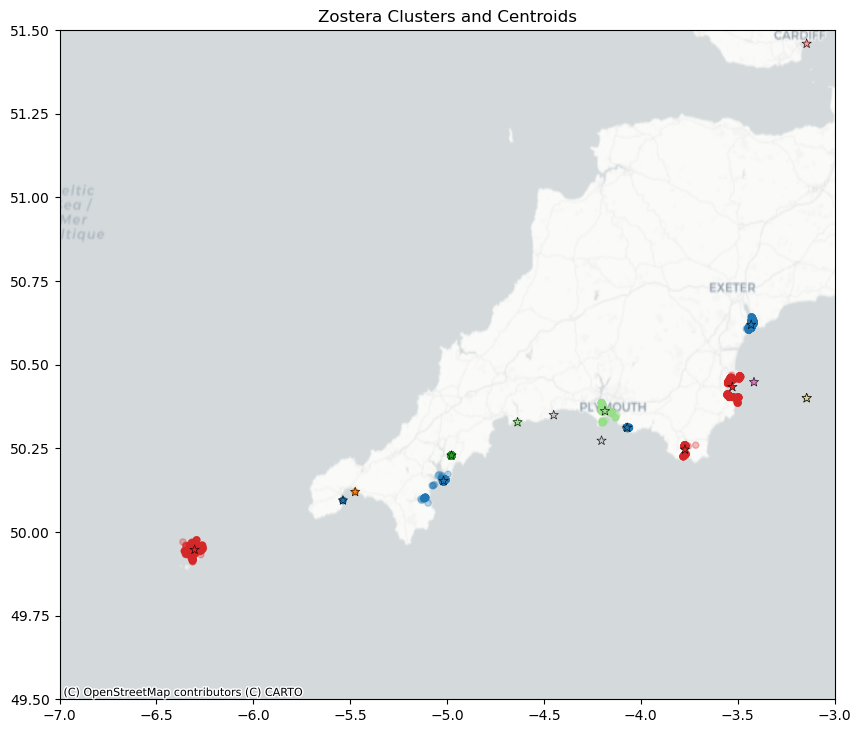

In [44]:
# Create the plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot original points, colored by cluster
zostera_gdf.plot(color=zostera_gdf["color"], ax=ax, markersize=20, alpha=0.3)

# Plot centroids
zostera_centroids.plot(ax=ax, color=zostera_centroids["color"], marker='*', markersize=50, edgecolor='black', linewidth=0.4)
ax.set_xlim([-7, -3])
ax.set_ylim([49.5, 51.5])
# ax.set_xlim([-10, 2])
# ax.set_ylim([49, 61])

ax.set_title('Zostera Clusters and Centroids')

cx.add_basemap(ax, crs=zostera_gdf.crs, source=cx.providers.CartoDB.Positron)
plt.show()
fig.savefig(os.path.join(FIGURES_DIR, 'zostera_clusters_sw.png'))

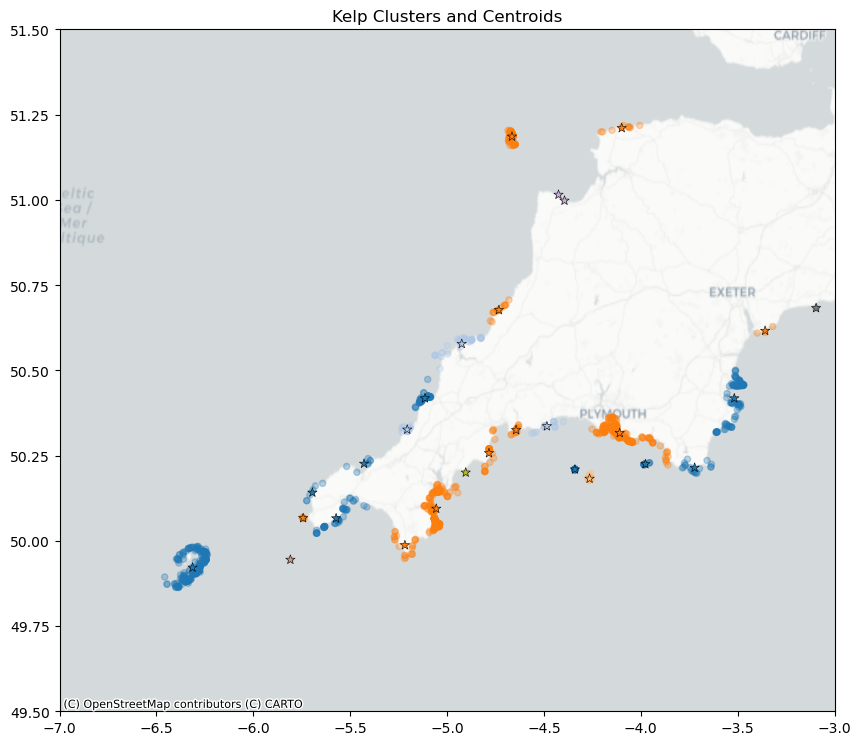

In [45]:
# Create the plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot original points, colored by cluster
kelp_gdf.plot(color=kelp_gdf["color"], ax=ax, markersize=20, alpha=0.3)

# Plot centroids
kelp_centroids.plot(ax=ax, color=kelp_centroids["color"], marker='*', markersize=50, edgecolor='black', linewidth=0.4)
ax.set_xlim([-7, -3])
ax.set_ylim([49.5, 51.5])
# ax.set_xlim([-10, 2])
# ax.set_ylim([49, 61])

ax.set_title('Kelp Clusters and Centroids')

cx.add_basemap(ax, crs=kelp_gdf.crs, source=cx.providers.CartoDB.Positron)
plt.show()
fig.savefig(os.path.join(FIGURES_DIR, 'kelp_clusters_sw.png'))

## Save results

In [46]:
save_gdf_shp = os.path.join(DATA_DIR, 'OSPARHabitats2022_Points_clustered/OSPAR2022Points.shp')
save_centroids_shp = os.path.join(DATA_DIR, 'OSPARHabitats2022_Points_clustered/OSPAR2022Points_centroids.shp')

In [47]:
gdf = gdf.drop(columns=['survey_color', 'color'])
centroids_gdf = centroids_gdf.drop(columns=['color'])

In [48]:
gdf.to_file(save_gdf_shp)
centroids_gdf.to_file(save_centroids_shp)